# Topic: Predicting the 1,500 Meters Run's Finishing Times Using Olympic Data

# 1. Background and Introduction
During the 120 history of the Olympic games there is only one race every 4 years. The question that I am trying to answer is can I predict finishing time instead of based on the explanatory variables using regression modeling. I want to build a model that can predict a runner’s finishing time. I will use correlation to determine the effect age, height, or weight has on the 1,500-meter event. My explanatory variables are sex (categorical), age (numerical), height (numerical), weight (numerical), the team (categorical), and year (numerical). My data comes from www.sports-reference.com. 

# 2. Data and Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr

In [2]:
raw_data = pd.read_excel("StatsData.xlsx")

In [3]:
df = raw_data.copy()

My sample size began as 123. This sample includes every athlete that completed in the Olympic 1,500 from 1896-2016. Since, I wanted to prdeict the winning time for the male and female 1,500, I excluded all runners that did not receive a medal.

In [4]:
df.shape

(123, 10)

# 2.a Data 
For my analysis, I used an Olympic dataset for male and female runners from 1896 to 2016 that placed, which includes 123 cases, each case representing a runner who ran at the Olympics in the 1,500 meters race. Some limitations include that the data are dependent on summary information recorded on www.sports-reference.com. I used data from 1896 to 2016 because it wanted to look at the 120 year history of the 1,500 meters race in the Olympics. The four predictors that I wanted to investigate were sex, height(cm), weight(kg), and time in mintues. The first one was dichotomous, while the other three are quantitative variables. Sex is a dichotomous variable that only exist in one of two categories. 

In [5]:
df.head(10)

,Name,Sex,Age,Height,Weight,Country,Year,City,Medal,Time
0,"Edwin Harold ""Teddy"" Flack",M,22,NaN,NaN,AUS,1896,Athina,Gold,00:04:33
1,Albin Georges Lermusiaux,M,21,NaN,NaN,FRA,1896,Athina,Bronze,00:04:36
2,Arthur Charles Blake,M,24,NaN,NaN,USA,1896,Athina,Silver,04:34
3,Henry Lon mile Deloge,M,25,NaN,NaN,FRA,1900,Paris,Silver,00:04:07
4,Charles Bennett,M,29,NaN,NaN,GBR,1900,Paris,Gold,00:04:06
5,John Bray,M,24,NaN,NaN,USA,1900,Paris,Bronze,00:04:07
6,Lacey Earnest Hearn,M,23,NaN,NaN,USA,1904,St. Louis,Bronze,NaN
7,"James Davies ""Jim"" Lightbody",M,22,173.0,61.0,USA,1904,St. Louis,Gold,00:04:05
8,"William Franklyn ""Bill"" Verner",M,21,NaN,NaN,USA,1904,St. Louis,Silver,04:06
9,John McGough,M,25,NaN,NaN,GBR,1906,Athina,Silver,00:04:12.600000


Out of the 123 cases, there were missing vaules for heirght(10), weight(10), and time(2). Since, my analyis depends on those varibles, I will exclude runners with missing data from the dataset.

In [6]:
df.isnull().sum()

Name        0
Sex         0
Age         0
Height     10
Weight     10
Country     0
Year        0
City        0
Medal       0
Time        2
dtype: int64

After dropping the null or NaN values, I am left with a dataset of 112 cases.

In [7]:
df = df.dropna()
df.shape

(112, 10)

# 2.b Variables

Then I had to format all the varibles for the regression modeling. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 7 to 122
Data columns (total 10 columns):
Name       112 non-null object
Sex        112 non-null object
Age        112 non-null int64
Height     112 non-null float64
Weight     112 non-null float64
Country    112 non-null object
Year       112 non-null int64
City       112 non-null object
Medal      112 non-null object
Time       112 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 9.6+ KB


Before, I formatted the varaibles, I dropped the varibles that I was not looking at like Name, Country, City,and Medal.

In [9]:
df = df.drop(['Name', 'Country','City', 'Medal'], axis = 1)

I began with Time. Time was originally formated as an object. First, I had to format the Time variable into H:M:S.

In [10]:
df['Time'] = df['Time'].apply(lambda x: x.strftime('%H:%M:%S %Z'))

Secondly, I converted Time to a timedelta64[ns] value, this allows me to mulitple Time.

In [11]:
df['Time']=pd.to_timedelta(df['Time'])

This allowed me to converted time into minutes. Now that the time is in minutes, I can use pearson correlation later in the anylasis.

In [12]:
df['Time'] = ((df['Time'].dt.components.minutes + df['Time'].dt.components.seconds*0.0166667))

I had to change Height from a float to an interger for the multiple linear regression model.

In [13]:
df["Height"] = df["Height"].astype(int)

I had to changed the unit of measurment for the Weight variable from kg to lbs. I had to change Weight from a float to an interger for the multiple linear regression model.

In [14]:
df['Weight'] = 2.20462 * df['Weight']
df["Weight"] = df["Weight"].astype(int)

I wanted to see the progression of runner's times over the years. There seems to a decrase in time from 1864 to 1960. Form 1960 t0 2016 there seems to be a great deal of variability.

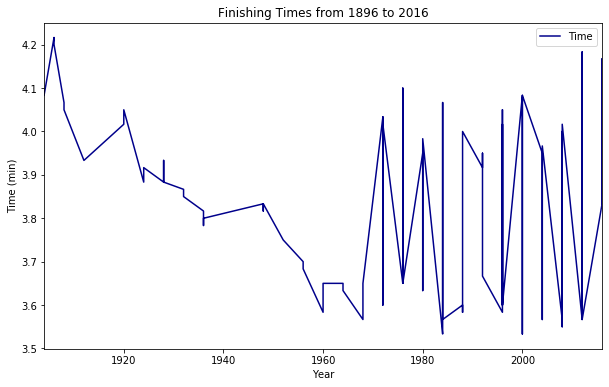

In [15]:
df.plot(kind='line', x='Year', y='Time', figsize=(10, 6), color='darkblue')
 
plt.title('Finishing Times from 1896 to 2016')
plt.xlabel('Year')
plt.ylabel('Time (min)')
 
plt.show()

Since women didn't start racing until 1972, that could be the reason for the variability. Therefore, I separted the dataset for male and female athltets for later analysis.

In [16]:
# All the female atheles are in this dataframe
female = df[df['Sex']=='F']
# All the male atheles are in this dataframe
male = df[df['Sex']=='M']

I converted Sex into numbers so that they could be included in the persaons correlation.

In [17]:
sex_mapping = {"M": 0, "F": 1}

In [18]:
df['Sex'] = df['Sex'].map(sex_mapping)

I set the index to Year so when I do future analysis it corresonds to a year.

In [19]:
df.set_index('Year', inplace=True)

In summary:
    * Time is in minutes
    * Height is in centimeters
    * Weight is in pounds
    * Age is in years
    * Sex, males are 0 and females are 1

# 2.c Univariate analyses  

The dataset contains 112 cases and no missing data. 
* For Age, the median (50%) value is 25 years old, the range is (35-19) 16 years, and the standard deviation is 3.514 years.
* For Height, the median (50%) value is 173.5 centimeters, the range is (191-153) 38 centimeters, and the standard deviation is 7.974 centimeters.
* For Time, the median (50%) value is 3.833 minutes, the range is (4.217-3.533) 0.684 minutes, and the standard deviation is 0.206 minutes.
* For Weight, the median (50%) value is 135.58 pounds, the range is (176.370-92.594) 83.776 pounds, and the standard deviation is 18.114 pounds.

In [20]:
df.describe()

,Sex,Age,Height,Weight,Time
count,112.000000,112.000000,112.000000,112.000000,112.000000
mean,0.321429,25.330357,173.633929,134.535714,3.830358
std,0.469124,3.514163,7.974052,18.092320,0.206321
min,0.000000,19.000000,153.000000,92.000000,3.533334
25%,0.000000,23.000000,168.750000,122.500000,3.633335
50%,0.000000,25.000000,173.500000,135.000000,3.833335
75%,1.000000,27.000000,180.000000,147.500000,4.016667
max,1.000000,35.000000,191.000000,176.000000,4.216667


Sex is dichotomous so I looked at the mode. 0 is the most frequently occurring value for Sex. Therefore, it is the mode of the data set. Since 0 reprsents males, there are more males in the dataset then females. The count indicates that there are 76 males in the dataset. This makes sense that there are more males because females did not start competing in th 1,500 until 1972.

In [21]:
from scipy import stats
stats.mode(df['Sex'])

ModeResult(mode=array([0]), count=array([76]))

I looked at the shape of my variables. I did not interpate the shape for Sex because it is a dichotomous variable.
* For Age, the distribution unimodal and positively (right) skewed.
* For Height, the distribution unimodal and roughly symmetric.
* For Time, the distribution unimodal and positively (right) skewed. 
* For Weight, the distribution unimodal and roughly symmetric. 

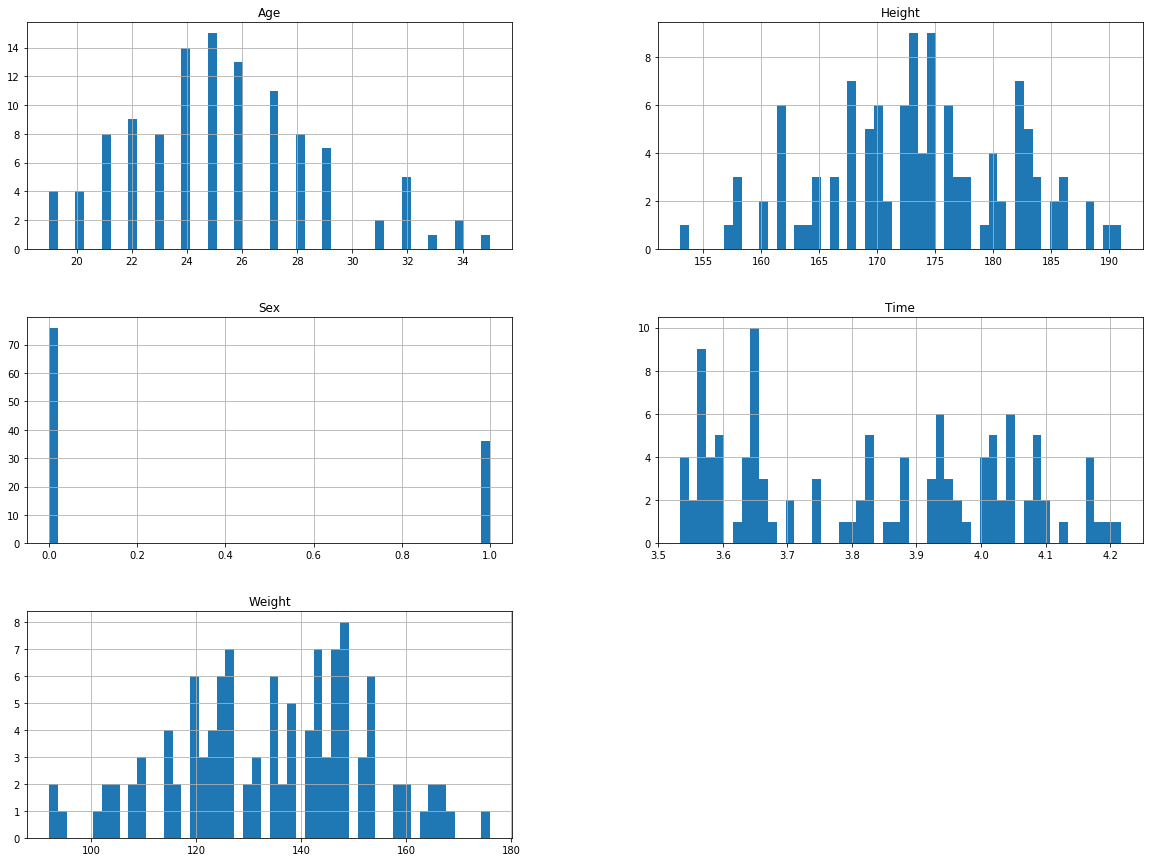

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

# 2.d Exploratory Data Analysis

I began by calculating Pearson correlation for the other varibles in relation to time in minutes. 

In the exploratory data analysis, the most notable finding was the strong positive correlation (r = 0.665) between Time(mintues) and Sex. There is a strong negative correlation (r = -0.557) between Time(mintues) and Height(cm). There is a moderate negative correlation (r = -0.459) between Time(mintues) and Weight(lbs). There is a weak positive correlation (r = 0.147) between Time(mintues) and Age(years). Age(years) and Weight(lbs) will be removed from the model becuse they do not have a strong correlation with Time(minutes). The rest of the varaibles will remain in the model.

In [23]:
corr_matrix = df.corr()
corr_matrix['Time'].sort_values(ascending=False)

Time      1.000000
Sex       0.664617
Age       0.147573
Weight   -0.458566
Height   -0.556742
Name: Time, dtype: float64

Males run faster in the 1,500 meters race than female, on average.

Text(0.5, 0.98, 'The Effect of Sex on Finishing Times')

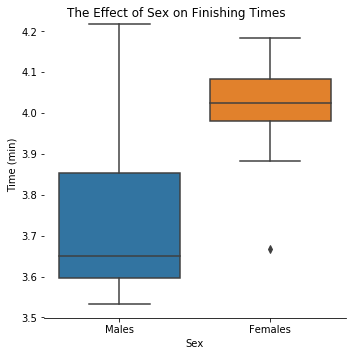

In [24]:
a = sns.catplot(x='Sex', y='Time', data=df, kind='box')
(a.set_axis_labels("Sex","Time (min)")
  .set_xticklabels(["Males", "Females"])
  .despine(left=True))
a.fig.suptitle('The Effect of Sex on Finishing Times') 

Runners that are taller tend to run faster times than shorter runners and shorter runners tend to run slower times.

Text(0.5, 0.98, 'The Effect of Height on Finishing Times')

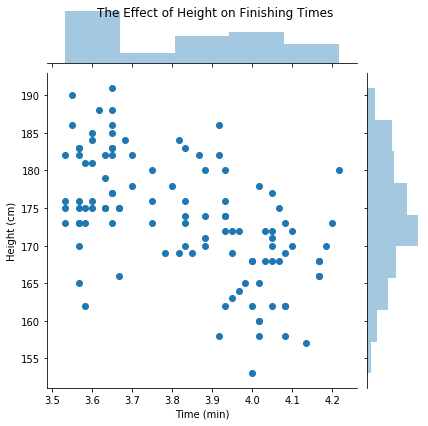

In [25]:
b = sns.jointplot(x ='Time', y='Height', data=df)
(b.set_axis_labels("Time (min)","Height (cm)"))
b.fig.suptitle('The Effect of Height on Finishing Times') 

Runners that weight more tend to run faster times and lighter runners tend to run slower times.

Text(0.5, 0.98, 'The Effect of Weight on Finishing Times')

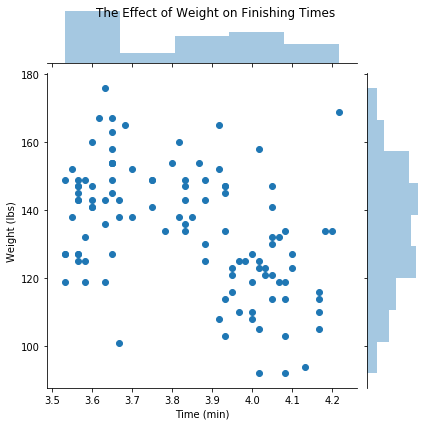

In [26]:
c = sns.jointplot(x='Time', y='Weight', data=df)
(c.set_axis_labels("Time (min)","Weight (lbs)"))
c.fig.suptitle('The Effect of Weight on Finishing Times') 

A weak correlation between Time(mintues) and Age(yrs) was found.

Text(0.5, 0.98, 'The Effect of Age on Finishing Times')

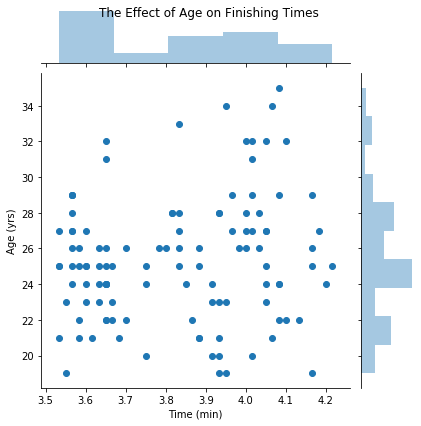

In [27]:
d = sns.jointplot(y='Age', x='Time', data=df)
(d.set_axis_labels("Time (min)","Age (yrs)"))
d.fig.suptitle('The Effect of Age on Finishing Times') 

# 3. Multiple linear regression Model 
I split the data into two sets, one with time in minutes, one without time in minutes. I also dropped Age and Weight from the datasets here since, it will not be used in the model.

In [28]:
X = df.drop(['Time','Age','Weight'], axis = 1)
y = df['Time']

# 3.a Analytic Methods

Question: Can you predict finishing time by sex, height, and weight of an athlete?

In order to predict the outcomes of the runner's times, I used multiple linear regression  modeling. 

In [29]:
#build training and testing dataset

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
import sklearn
from sklearn import linear_model

In [33]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_test, y_test)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# 3.b Final Model and Results

In [34]:
results = pd.DataFrame({
    'actual': y_test,
    'prediction': y_pred
})
results

,actual,prediction
Year,,
1972,4.033333,3.986169
1988,3.600001,3.696885
1908,4.050000,3.988772
1976,4.100000,3.986169
1972,4.033333,4.047619
1988,4.000000,4.047619
1952,3.750001,3.819784
1924,3.883335,3.804422
1920,4.050000,3.865872


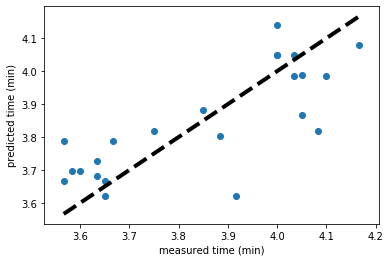

In [35]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('measured time (min)')
ax.set_ylabel('predicted time (min)')
plt.show()

# 4 Conclusion

I will now check the predictions against the actual values by using the RMSE metric, a metric commonly used to evaluate regression tasks:

In [36]:
test_set_rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))

The model is fitting well!!!
The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

In [37]:
print(test_set_rmse)

0.12569797099237356


Multiple linear regression is an useful algorithm for tracking the relationships of continuous variables. 

In [38]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Time   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          1.816e+04
Date:                Wed, 22 Apr 2020   Prob (F-statistic):                   2.50e-139
Time:                        12:29:14   Log-Likelihood:                          15.453
No. Observations:                 112   AIC:                                     -26.91
Df Residuals:                     110   BIC:                                     -21.47
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Sex            0.5478      0.042     13.004      0.000       0.464       0.631
Height         0.0210      0.000    152.977      0.000       0.021       0.021
==============================================================================
Omnibus:                        4.445   Durbin-Watson:                   0.943
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                4.098
Skew:                           0.466   Prob(JB):                        0.129
Kurtosis:                       3.089   Cond. No.                         364.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 4.a Multiple linear regression Results

I used an olympic data set. I conducted a multiple regression analysis to predict a runner's time (Time) from thier Sex and Height(cm). Weight(lbs) and Age(yrs) were excluded from the analysis due to not being statistically significant.

We can see that both Sex and Height are statistically significant in predicting (or estimating) a runner's finishing time. 

The regression equation is:
Time = 0.5478(Sex) + 0.0210(Height)

* The slope of Sex is statistically significant (p < .001). On average, female runners ran 0.5478 minutes more than male runners.
 
* The slope of Height is statistically significant (p < .001). The interpretation for the slope of Height is that as Height increases by 1, Time will increase by 0.0210 holding Sex constant. 

The value of R2 for the regression is .997, indicating that about 99.7% of the variation in runner's time can be explained by explanatory variables: Sex and Height (cm). Those explanatory variables are good predictors of runner's time in the 1,500 meter race.